# Modeling - Binary Classification (Gun vs. Not Gun)

In [87]:
import joblib
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.layers import Dropout
from keras.applications import imagenet_utils

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime
original_start = datetime.datetime.now()
start = datetime.datetime.now()

import os, shutil

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [3]:
# create directions for guns and not guns
data_gun_dir = 'image_data/gun'
data_not_gun_dir = 'image_data/not_gun/'

# new directory for the train test validation split
new_dir = 'split/'

In [4]:
# add gun images 
imgs_gun = [file for file in os.listdir(data_gun_dir) if file.endswith('.jpg')]

In [5]:
# check first ten 
imgs_gun[0:10]

['120px-RugerMuzzelite.jpg',
 'armas (2311).jpg',
 '120px-NEF_B32.jpg',
 'armas (2741).jpg',
 '120px-NambuType14Pistol.jpg',
 'armas (695).jpg',
 'armas (1497).jpg',
 'armas (1182).jpg',
 'armas (380).jpg',
 'armas (1478).jpg']

In [6]:
len(imgs_gun)

3967

In [7]:
# add not gun images
imgs_not_gun = [file for file in os.listdir(data_not_gun_dir) if file.endswith('.jpg')]

In [8]:
imgs_not_gun[0:10]

['-478.jpg',
 'smartphone_0049_box1.jpg',
 'smartphone_0048_box1.jpg',
 '004_0101.jpg',
 '-322.jpg',
 'smartphone_0817_box1.jpg',
 'smartphone_0487_box1.jpg',
 '-444.jpg',
 '-450.jpg',
 'smartphone_0816_box1.jpg']

In [9]:
len(imgs_not_gun)

2150

In [10]:
# below code creates new directory if not already created
# os.mkdir(new_dir)

In [11]:
# from the new directory, create new training, test, and val folders to store the guns and not guns
train_folder = os.path.join(new_dir, 'train')
train_gun = os.path.join(train_folder, 'gun')
train_not_gun = os.path.join(train_folder, 'not_gun')

test_folder = os.path.join(new_dir, 'test')
test_gun = os.path.join(test_folder, 'gun')
test_not_gun = os.path.join(test_folder, 'not_gun')

val_folder = os.path.join(new_dir, 'validation')
val_gun = os.path.join(val_folder, 'gun')
val_not_gun = os.path.join(val_folder, 'not_gun')

In [12]:
# os.mkdir(test_folder)
# os.mkdir(test_gun)
# os.mkdir(test_not_gun)

# os.mkdir(train_folder)
# os.mkdir(train_gun)
# os.mkdir(train_not_gun)

# os.mkdir(val_folder)
# os.mkdir(val_gun)
# os.mkdir(val_not_gun)

Now we will slice the images from `imgs_not_gun` into train, validation, and test folders and do the same for `imgs_gun` into train, validation, and test folders.

**Not Gun Images**

In [13]:
# train not_gun
imgs = imgs_not_gun[:1290]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(train_not_gun, img)
    shutil.copyfile(origin, destination)
# validation not_gun
imgs = imgs_not_gun[1290:1720]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(val_not_gun, img)
    shutil.copyfile(origin, destination)
# test not_gun
imgs = imgs_not_gun[1720:]
for img in imgs:
    origin = os.path.join(data_not_gun_dir, img)
    destination = os.path.join(test_not_gun, img)
    shutil.copyfile(origin, destination)

**Gun Images**

In [14]:
# train gun
imgs = imgs_gun[:2270]  # 2270 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(train_gun, img)
    shutil.copyfile(origin, destination)
    
# validation gun
imgs = imgs_gun[2270:3027]  # 757 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(val_gun, img)
    shutil.copyfile(origin, destination)

# test gun
imgs = imgs_gun[3027:]  # 757 images
for img in imgs:
    origin = os.path.join(data_gun_dir, img)
    destination = os.path.join(test_gun, img)
    shutil.copyfile(origin, destination)

Check how many images are in each set.

In [15]:
print('There are', len(os.listdir(train_gun)), 'gun images in the train set')
print('There are', len(os.listdir(val_gun)), 'gun images in the validation set')
print('There are', len(os.listdir(test_gun)), 'gun images in the test set')

There are 2392 gun images in the train set
There are 896 gun images in the validation set
There are 940 gun images in the test set


In [16]:
print('There are', len(os.listdir(train_not_gun)), 'not gun images in the train set')
print('There are', len(os.listdir(val_not_gun)), 'not gun images in the validation set')
print('There are', len(os.listdir(test_not_gun)), 'not gun images in the test set')

There are 1290 not gun images in the train set
There are 437 not gun images in the validation set
There are 450 not gun images in the test set


## Preprocessing Images 

- Normalize
- Set up image size
- Set up size of training, validation, and test sets

In [17]:
# get all the data in the directory split/train, and reshape them
# normalizees by rescaling
# set image size to 256 x 256
# batch size varies for each set size

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                     train_folder, 
                                                     target_size=(224, 224),
                                                     classes = ['not_gun', 'gun'],
                                                     batch_size=3000) # 3682 total from train

# get all the data in the directory split/validation, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                   val_folder, 
                                                   target_size=(224, 224),
                                                   classes = ['not_gun', 'gun'],
                                                   batch_size = 1000) # 1333 total from val

# get all the data in the directory split/test, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
                                                    test_folder, 
                                                    target_size=(224, 224),
                                                    classes = ['not_gun', 'gun'],
                                                    batch_size = 1000) # 1390 total from test

Found 3682 images belonging to 2 classes.
Found 1333 images belonging to 2 classes.
Found 1390 images belonging to 2 classes.


In [18]:
# create the data sets and label the images as gun or not gun
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [19]:
# check shape of images in train set
train_images.shape

(3000, 224, 224, 3)

In [20]:
# check labels for train
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [21]:
train_generator.class_indices

{'not_gun': 0, 'gun': 1}

Label: [1. 0.]


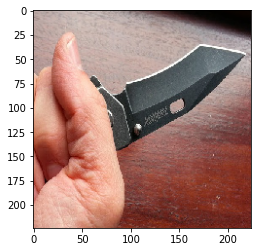

In [22]:
# check an example gun image
sample_train_image = train_images[105]
sample_train_label = train_labels[105]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

Label: [0. 1.]


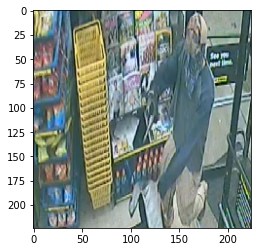

In [23]:
# check an example not gun image
sample_train_image = train_images[0]
sample_train_label = train_labels[0]
display(plt.imshow(sample_train_image))
print('Label: {}'.format(sample_train_label))

### Visualize the Image Dataset

In [24]:
# function that plots images and labels
def plots(ims, figsize = (20,4), rows = 1, interp = False, titles = None):
    """
    Takes in image set (recommend to slice for large sets); and image labels
    and plots a row of the images with associated labels.
    """
    if type(ims[0]) is np.ndarray:
        ims - np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims - ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 -- 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i +1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


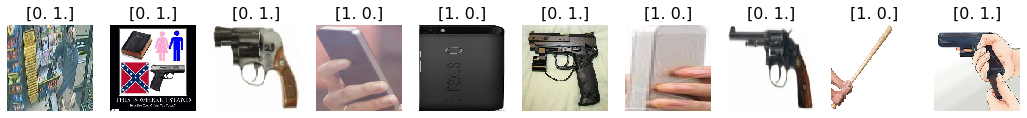

In [25]:
# peek at 10 images in the train set
plots(train_images[0:10], titles = train_labels[0:10])

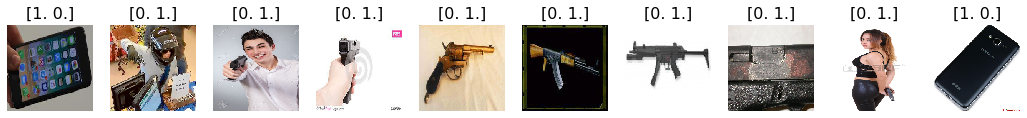

In [26]:
# peek at 10 images in the test set
plots(test_images[500:510], titles = test_labels[500:510])

In [27]:
# Explore dataset again
m_train = train_images.shape[0]  # number of images in train
num_px = train_images.shape[1]  # number of pixels
m_test = test_images.shape[0]  # number of images in test
m_val = val_images.shape[0]  # number of images in validation 

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print('-'*40)
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print('-'*40)
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print('-'*40)
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 3000
Number of testing samples: 1000
Number of validation samples: 1000
----------------------------------------
train_images shape: (3000, 224, 224, 3)
train_labels shape: (3000, 2)
----------------------------------------
test_images shape: (1000, 224, 224, 3)
test_labels shape: (1000, 2)
----------------------------------------
val_images shape: (1000, 224, 224, 3)
val_labels shape: (1000, 2)


### Reshaping the images

In [28]:
# reshapes the images to (num of images in set, num of pixels ie. 64 x 64 x 3 = 12288)
train_img = train_images.reshape(train_images.shape[0], -1) 
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print("Train", train_img.shape)
print("Validation", val_img.shape)
print("Test", test_img.shape)

Train (3000, 150528)
Validation (1000, 150528)
Test (1000, 150528)


Lets check the class balance for each image set:

In [29]:
# check train labels shape; currently as a binary tuple label
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [30]:
# get array of not gun vs. gun image labels
train_label_sum = sum(train_labels)
val_label_sum = sum(val_labels)
test_label_sum = sum(test_labels)

# get percentage of gun images in each set
train_gun_balance = round(train_label_sum[1] / len(train_labels),3)
val_gun_balance = round(val_label_sum[1] / len(val_labels),3)
test_gun_balance = round(test_label_sum[1] / len(test_labels),3)

print("Percentage of Gun Images in Train Set:", train_gun_balance)
print("Percentage of Gun Images in Validation Set:", val_gun_balance)
print("Percentage of Gun Images in Test Set:", test_gun_balance)


Percentage of Gun Images in Train Set: 0.647
Percentage of Gun Images in Validation Set: 0.667
Percentage of Gun Images in Test Set: 0.671


Finally, to model, we need to reshape the target variable so that it is in the correct shape.

In [31]:
# reshape the target, changes target values to binary (1 or 0)
train_y = np.reshape(train_labels[:,1], (3000,1))
test_y = np.reshape(test_labels[:,1], (1000,1))
val_y = np.reshape(val_labels[:,1], (1000,1))

In [32]:
# check test_y 
test_y[0:15]

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [33]:
# verify test_y labels are correct with test set
test_labels[0:15]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [34]:
# check change
print(train_y)
print(train_y.shape)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]
(3000, 1)


## Build Baseline Dense Network

In [35]:
# Build a baseline fully connected model
np.random.seed(42)

baseline_model = models.Sequential()
baseline_model._name = "Baseline" # names the model

baseline_model.add(layers.Dense(64, activation='relu', input_shape=(150528,))) 

# 2 hidden layers
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(16, activation='relu'))

baseline_model.add(layers.Dense(1, activation='sigmoid')) 

Metal device set to: Apple M1


2022-08-03 10:21:00.450614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 10:21:00.451266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [36]:
baseline_model.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                9633856   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,636,481
Trainable params: 9,636,481
Non-trainable params: 0
_________________________________________________________________


In [37]:
# terminate training if doesnt improve on specified min_delta for 5 epochs
trainCallback = EarlyStopping(monitor='accuracy', min_delta = 1e-2, patience = 5)

**⏰ Below code runs for a few minutes**

In [38]:
baseline_model.compile(optimizer='adam',
              loss='binary_crossentropy', # for binary classification (gun or not gun)
              metrics=['accuracy'])

baseline_model = baseline_model.fit(train_img,
                                    train_y,
                                    epochs=50,
                                    batch_size=64,
                                    validation_data=(val_img, val_y),
                                    callbacks=[trainCallback])

Epoch 1/50


2022-08-02 13:37:02.394896: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-02 13:37:02.776188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 4.7332 - accuracy: 0.5993

2022-08-02 13:37:06.604508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 5s 94ms/step - loss: 4.7332 - accuracy: 0.5993 - val_loss: 1.2010 - val_accuracy: 0.6640
Epoch 2/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6474 - accuracy: 0.6713 - val_loss: 0.6320 - val_accuracy: 0.7030
Epoch 3/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6098 - accuracy: 0.6917 - val_loss: 1.1191 - val_accuracy: 0.4920
Epoch 4/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6082 - accuracy: 0.7073 - val_loss: 0.7769 - val_accuracy: 0.6010
Epoch 5/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6853 - accuracy: 0.6997 - val_loss: 0.7336 - val_accuracy: 0.6390
Epoch 6/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6693 - accuracy: 0.6943 - val_loss: 1.0537 - val_accuracy: 0.6940
Epoch 7/50
47/47 [==============================] - 4s 84ms/step - loss: 0.6281 - accuracy: 0.7197 - val_loss: 0.7861 - val_accuracy: 0.6220
Epoch 8/50
47/47 [======

**.pkl the file**

In [39]:
# # use the built-in open() function to open a file
# output_file = open("baseline_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(baseline_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://efbaa532-a94d-4245-aa56-c88dfed6ae9c/assets


In [38]:
# use the built-in open() function again, this time to read
model_file = open("baseline_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_baseline_model = joblib.load(model_file)
# close the file
model_file.close()

In [39]:
# create a helper function that returns loss and accuracy results from model
# also plots the loss and accuracy 

def model_results(mod, train_img, train_y, test_img, test_y):
    """ Takes in the model, image set, and array y of targets for training and test sets
        and returns the model's loss and accuracy scores.
        Also returns a plot of the training and validation scores. 
    """
    # returns loss and accuracy scores for training and test sets
    results_train = mod.model.evaluate(train_img, train_y)
    results_test = mod.model.evaluate(test_img, test_y)
    
    # get the accuracy and loss for training and validation
    acc = mod.history['accuracy']
    val_acc = mod.history['val_accuracy']
    loss = mod.history['loss']
    val_loss = mod.history['val_loss']
    epochs = range(len(acc))
    
    # return train and test loss and accuracy
    print("Train Results Loss:", round(results_train[0],5))
    print("Train Results Accuracy:", round(results_train[1], 5))
    print("-"* 50)
    print("Test Results Loss:", round(results_test[0],5))
    print("Test Results Accuracy:", round(results_test[1], 5))
    
    # plot the Traininng and Validation Accuracy and Loss
    plt.plot(epochs, acc, label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and Validation accuracy', fontweight = "bold")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and Validation loss', fontweight = "bold")
    plt.legend()
    plt.show()

### Baseline Model Results

2022-08-03 10:21:08.582758: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-03 10:21:08.797201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 49ms/step - loss: 0.6674 - accuracy: 0.7470
Train Results Loss: 0.48988
Train Results Accuracy: 0.768
--------------------------------------------------
Test Results Loss: 0.66743
Test Results Accuracy: 0.747


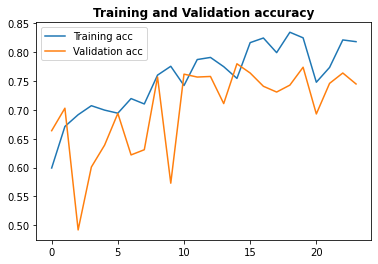

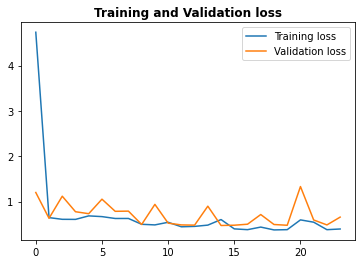

In [40]:
# get baseline model results
model_results(loaded_baseline_model, train_img, train_y, test_img, test_y)

In [41]:
# create helper function to plot test results as a confusion matrix
def get_test_results(mod, test_img, test_y):
    """
    Takes in the model, test image set, and test_y set
    and returns the model's accuracy and confusion matrix.
    """
    # return the loss and accuracy scores for the test set
    mod.model.evaluate(test_img, test_y)
    
    # get probabilites from the prediction on the test image set
    y_proba = mod.model.predict(test_img)
    
    # get assigned index values; ie. predicted labels
    predicted = y_proba.round()

    # plot confusion matrix on test set
    cm = confusion_matrix(test_y, predicted)

    disp = ConfusionMatrixDisplay(
        display_labels = ['Not Gun', 'Gun'],
        confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    
    model_name = mod.model.name

    # labels, title and ticks

    plt.title(model_name + "\nGun & Not Gun Binary Classification Matrix")
    plt.show()
    

 3/32 [=>............................] - ETA: 1s

2022-08-03 10:21:23.384677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 60ms/step


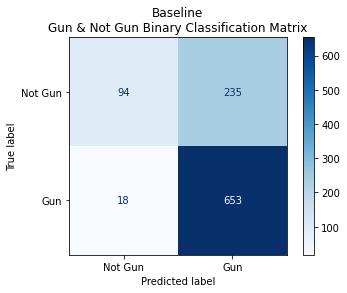

In [42]:
# get confusion matrix and test results for test image set
get_test_results(loaded_baseline_model, test_img, test_y)

## Building a CNN

### CNN Baseline V1

In [45]:
cnn_model = models.Sequential()
cnn_model._name = "CNN"

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

In [46]:
cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0       

**⏰ Below code runs for about 8 minutes**

In [47]:
# create a CNN model
cnn_model = cnn_model.fit(train_images,
                            train_y,
                            epochs=20,
                            batch_size=64,
                            validation_data=(val_images, val_y),
                            callbacks=[trainCallback])

Epoch 1/20


2022-08-02 13:42:27.447218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6470

2022-08-02 13:42:42.213117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 18s 356ms/step - loss: 0.6378 - accuracy: 0.6470 - val_loss: 0.6076 - val_accuracy: 0.6660
Epoch 2/20
47/47 [==============================] - 17s 372ms/step - loss: 0.6069 - accuracy: 0.6537 - val_loss: 0.5798 - val_accuracy: 0.6670
Epoch 3/20
47/47 [==============================] - 17s 372ms/step - loss: 0.5900 - accuracy: 0.6573 - val_loss: 0.5600 - val_accuracy: 0.6740
Epoch 4/20
47/47 [==============================] - 17s 372ms/step - loss: 0.5691 - accuracy: 0.6717 - val_loss: 0.7607 - val_accuracy: 0.4600
Epoch 5/20
47/47 [==============================] - 17s 370ms/step - loss: 0.5432 - accuracy: 0.6923 - val_loss: 0.5226 - val_accuracy: 0.7070
Epoch 6/20
47/47 [==============================] - 17s 366ms/step - loss: 0.5372 - accuracy: 0.7037 - val_loss: 0.5130 - val_accuracy: 0.7390
Epoch 7/20
47/47 [==============================] - 18s 376ms/step - loss: 0.5165 - accuracy: 0.7277 - val_loss: 0.4845 - val_accuracy: 0.7420
Epoch 8/20

**.pkl the file**

In [48]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://fb63b82b-31cd-4d68-9c8a-408a533f5ee4/assets


INFO:tensorflow:Assets written to: ram://fb63b82b-31cd-4d68-9c8a-408a533f5ee4/assets


In [43]:
# use the built-in open() function again, this time to read
cnn_model_file = open("cnn_model.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model = joblib.load(cnn_model_file)
# close the file
cnn_model_file.close()

### CNN Baseline V1 Results

2022-08-03 10:21:42.576635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 69ms/step - loss: 0.3877 - accuracy: 0.8180
Train Results Loss: 0.31298
Train Results Accuracy: 0.865
--------------------------------------------------
Test Results Loss: 0.38771
Test Results Accuracy: 0.818


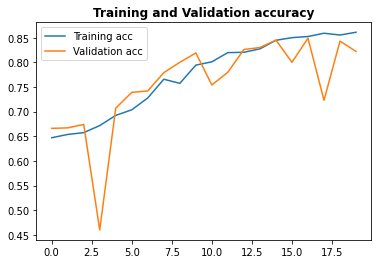

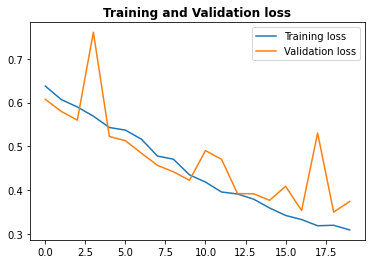

In [44]:
# get model results
model_results(loaded_cnn_model, train_images, train_y, test_images, test_y)

 2/32 [>.............................] - ETA: 3s

2022-08-03 10:21:53.261654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 73ms/step


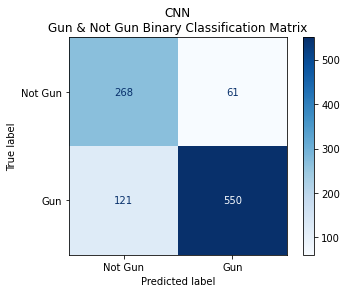

In [45]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model, test_images, test_y)

### CNN Tuning V2

In [48]:
cnn_model_2 = models.Sequential()
cnn_model_2._name = "CNN2"

cnn_model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))

cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_2.add(layers.MaxPooling2D((2, 2)))

cnn_model_2.add(layers.Flatten())
cnn_model_2.add(layers.Dense(64, activation='relu'))
cnn_model_2.add(layers.Dense(1, activation='sigmoid'))  

cnn_model_2.compile(loss='binary_crossentropy',
              optimizer="adam",  # change to adam optimizer
              metrics=['accuracy'])

In [49]:
# tf.config.run_functions_eagerly(True)

**⏰ Below code runs for about 6 minutes**

In [50]:
# create a CNN model 2
cnn_model_2 = cnn_model_2.fit(train_images,
                                train_y,
                                epochs=20,
                                batch_size=64,
                                validation_data=(val_images, val_y),
                                callbacks=[trainCallback])

Epoch 1/20


2022-08-03 10:22:37.035808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.6713

2022-08-03 10:22:55.810186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 21s 406ms/step - loss: 0.6874 - accuracy: 0.6713 - val_loss: 0.5224 - val_accuracy: 0.7370
Epoch 2/20
47/47 [==============================] - 17s 372ms/step - loss: 0.4783 - accuracy: 0.7737 - val_loss: 0.4764 - val_accuracy: 0.7600
Epoch 3/20
47/47 [==============================] - 17s 373ms/step - loss: 0.3829 - accuracy: 0.8287 - val_loss: 0.3977 - val_accuracy: 0.8320
Epoch 4/20
47/47 [==============================] - 17s 370ms/step - loss: 0.2978 - accuracy: 0.8797 - val_loss: 0.3593 - val_accuracy: 0.8530
Epoch 5/20
47/47 [==============================] - 17s 372ms/step - loss: 0.2908 - accuracy: 0.8703 - val_loss: 0.3416 - val_accuracy: 0.8720
Epoch 6/20
47/47 [==============================] - 18s 376ms/step - loss: 0.2145 - accuracy: 0.9130 - val_loss: 0.3234 - val_accuracy: 0.8850
Epoch 7/20
47/47 [==============================] - 17s 371ms/step - loss: 0.1667 - accuracy: 0.9313 - val_loss: 0.3527 - val_accuracy: 0.8750
Epoch 8/20

**.pkl the file**

In [51]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model_2.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model_2, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://49dd6c0e-afa3-4491-9883-fc0ede85b7fe/assets


INFO:tensorflow:Assets written to: ram://49dd6c0e-afa3-4491-9883-fc0ede85b7fe/assets


In [52]:
# use the built-in open() function again, this time to read
cnn_model_2_file = open("cnn_model_2.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model_2 = joblib.load(cnn_model_2_file)
# close the file
cnn_model_2_file.close()

### CNN Tuning V2 Results

32/32 [==============================] - 2s 51ms/step - loss: 0.8087 - accuracy: 0.8900
Train Results Loss: 0.00049
Train Results Accuracy: 1.0
--------------------------------------------------
Test Results Loss: 0.8087
Test Results Accuracy: 0.89


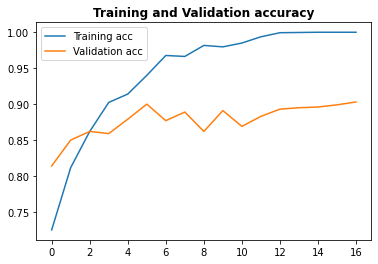

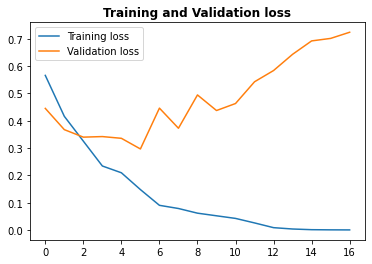

In [157]:
# get model results
model_results(loaded_cnn_model_2, train_images, train_y, test_images, test_y)

32/32 [==============================] - 2s 72ms/step


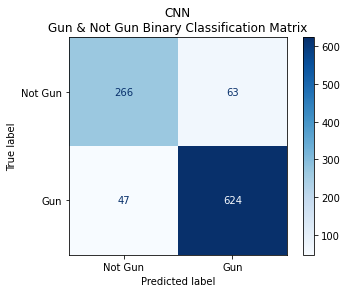

In [158]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model_2, test_images, test_y)

There is a bit of overfitting after changing the model to an Adam optimizer. Lets reduce the overfitting with regularization. 

### CNN Tuning V3 with L1 (Lasso) Regularization

In [96]:
# establish the regularization strength of lambda
reg_l1 = l1(3e-3) # 1e-5 to .1

In [72]:
cnn_model_3 = models.Sequential()
cnn_model_3._name = "CNN3RegL1"

cnn_model_3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))

cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(32, (4, 4), activation='relu')) 
cnn_model_3.add(layers.MaxPooling2D((2, 2)))

cnn_model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_3.add(layers.MaxPooling2D((2, 2)))
s
cnn_model_3.add(layers.Flatten())
cnn_model_3.add(layers.Dense(64, 
                             activation='relu',
                             kernel_regularizer = reg_l1)) # added l1 regularization
cnn_model_3.add(layers.Dense(1, activation='sigmoid'))  

cnn_model_3.compile(loss='binary_crossentropy',
              optimizer="adam",  
              metrics=['accuracy'])

**⏰ Below code runs for about 7-8 minutes**

In [73]:
# create a CNN model 3
cnn_model_3 = cnn_model_3.fit(train_images,
                                train_y,
                                epochs=20,
                                batch_size=64,
                                validation_data=(val_images, val_y),
                                callbacks=[trainCallback])

Epoch 1/20


2022-08-03 10:46:23.011215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 9.4081 - accuracy: 0.6240

2022-08-03 10:46:39.961640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 20s 400ms/step - loss: 9.4081 - accuracy: 0.6240 - val_loss: 2.1525 - val_accuracy: 0.6680
Epoch 2/20
47/47 [==============================] - 18s 388ms/step - loss: 1.8243 - accuracy: 0.6917 - val_loss: 1.7301 - val_accuracy: 0.7170
Epoch 3/20
47/47 [==============================] - 18s 377ms/step - loss: 1.6734 - accuracy: 0.7097 - val_loss: 1.6627 - val_accuracy: 0.7260
Epoch 4/20
47/47 [==============================] - 17s 372ms/step - loss: 1.7665 - accuracy: 0.7103 - val_loss: 1.8076 - val_accuracy: 0.7150
Epoch 5/20
47/47 [==============================] - 18s 385ms/step - loss: 1.6725 - accuracy: 0.7403 - val_loss: 1.5907 - val_accuracy: 0.7660
Epoch 6/20
47/47 [==============================] - 18s 375ms/step - loss: 1.5954 - accuracy: 0.7607 - val_loss: 1.6737 - val_accuracy: 0.7970
Epoch 7/20
47/47 [==============================] - 18s 374ms/step - loss: 1.5872 - accuracy: 0.7740 - val_loss: 1.5384 - val_accuracy: 0.7820
Epoch 8/20

**.pkl the file**

In [75]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model_3.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model_3, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

In [76]:
# use the built-in open() function again, this time to read
cnn_model_3_file = open("cnn_model_3.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model_3 = joblib.load(cnn_model_3_file)
# close the file
cnn_model_3_file.close()

### CNN Tuning V3 with L1 (Lasso) Regularization Results

2022-08-03 10:54:16.815254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 71ms/step - loss: 1.3831 - accuracy: 0.8720
Train Results Loss: 1.30861
Train Results Accuracy: 0.89
--------------------------------------------------
Test Results Loss: 1.38315
Test Results Accuracy: 0.872


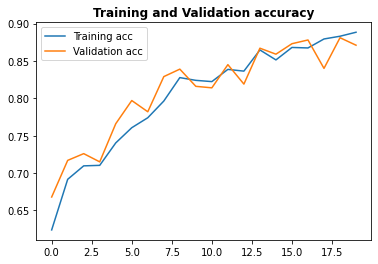

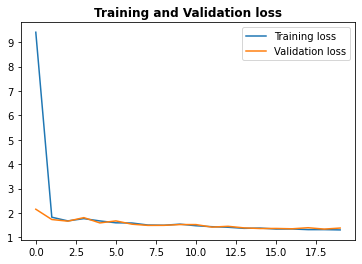

In [77]:
# get model results
model_results(loaded_cnn_model_3, train_images, train_y, test_images, test_y)

 2/32 [>.............................] - ETA: 3s

2022-08-03 10:54:37.383416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 76ms/step


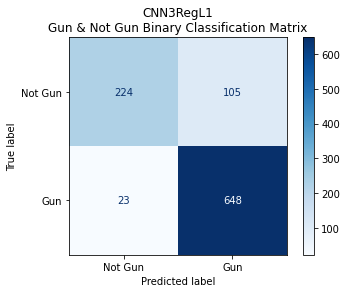

In [78]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model_3, test_images, test_y)

We fixed the issue of overfitting by simply adding a L1 regularization to the last layer of the previous CNN model. 

Also, this is our **best** performing model so far, with a accuracy of 87% on the test set, and recall of 97%. 

In this scenario, the recall score is defined as the total amount of correctly predicted 'gun' images (True Positives) over the entirety of True Positives and False Negatives (predicted not gun when actually a gun). 

Lets now see what a L2 regularization does and attempt to improve from here. 

### CNN Tuning V4 with L2 (Ridge) Regularization

In [80]:
# establish the regularization strength of lambda
reg_l2 = l2(3e-3) # 1e-5 to .1

In [81]:
cnn_model_4 = models.Sequential()
cnn_model_4._name = "CNN4RegL2"

cnn_model_4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))

cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(32, (4, 4), activation='relu')) 
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_4.add(layers.MaxPooling2D((2, 2)))

cnn_model_4.add(layers.Flatten())
cnn_model_4.add(layers.Dense(64, 
                             activation='relu',
                             kernel_regularizer = reg_l2)) # added l2 regularization
cnn_model_4.add(layers.Dense(1, activation='sigmoid'))  

cnn_model_4.compile(loss='binary_crossentropy',
                      optimizer="adam",  
                      metrics=['accuracy'])

**⏰ Below code runs for about 7-8 minutes**

In [82]:
# create a CNN model 4
cnn_model_4 = cnn_model_4.fit(train_images,
                              train_y,
                              epochs=20,
                              batch_size=64,
                              validation_data=(val_images, val_y),
                              callbacks=[trainCallback])

Epoch 1/20


2022-08-03 11:07:40.668604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 0.9030 - accuracy: 0.6350

2022-08-03 11:07:57.620826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 20s 397ms/step - loss: 0.9030 - accuracy: 0.6350 - val_loss: 0.6962 - val_accuracy: 0.7000
Epoch 2/20
47/47 [==============================] - 18s 379ms/step - loss: 0.6295 - accuracy: 0.7360 - val_loss: 0.5574 - val_accuracy: 0.7900
Epoch 3/20
47/47 [==============================] - 18s 387ms/step - loss: 0.4949 - accuracy: 0.8097 - val_loss: 0.4938 - val_accuracy: 0.8150
Epoch 4/20
47/47 [==============================] - 18s 385ms/step - loss: 0.4211 - accuracy: 0.8527 - val_loss: 0.4792 - val_accuracy: 0.8090
Epoch 5/20
47/47 [==============================] - 18s 376ms/step - loss: 0.3767 - accuracy: 0.8650 - val_loss: 0.3854 - val_accuracy: 0.8550
Epoch 6/20
47/47 [==============================] - 17s 371ms/step - loss: 0.3302 - accuracy: 0.8913 - val_loss: 0.3971 - val_accuracy: 0.8680
Epoch 7/20
47/47 [==============================] - 17s 372ms/step - loss: 0.2999 - accuracy: 0.9060 - val_loss: 0.4097 - val_accuracy: 0.8630
Epoch 8/20

**.pkl the file**

In [83]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model_4.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model_4, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

INFO:tensorflow:Assets written to: ram://b1672b6a-d536-4556-86b8-2564debc7330/assets


INFO:tensorflow:Assets written to: ram://b1672b6a-d536-4556-86b8-2564debc7330/assets


In [84]:
# use the built-in open() function again, this time to read
cnn_model_4_file = open("cnn_model_4.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model_4 = joblib.load(cnn_model_4_file)
# close the file
cnn_model_4_file.close()

### CNN Tuning V4 with L2 (Ridge) Regularization Results

2022-08-03 11:14:54.383289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 74ms/step - loss: 0.4535 - accuracy: 0.8750
Train Results Loss: 0.16587
Train Results Accuracy: 0.978
--------------------------------------------------
Test Results Loss: 0.45352
Test Results Accuracy: 0.875


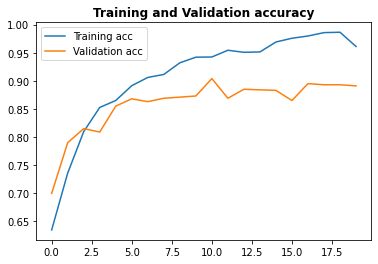

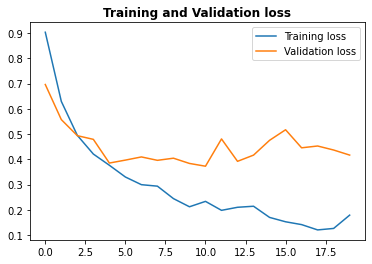

In [85]:
# get model results
model_results(loaded_cnn_model_4, train_images, train_y, test_images, test_y)

 2/32 [>.............................] - ETA: 3s

2022-08-03 11:15:12.308268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 75ms/step


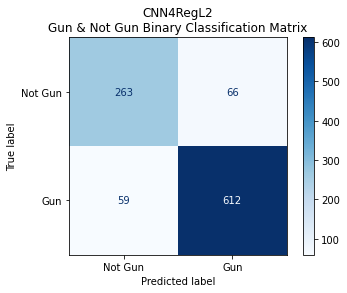

In [86]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model_4, test_images, test_y)

Changing the regularization layer from L1 (Lasso) to L2 (Ridge) actually does not resolve the overfitting issues. Applying an L1 regularization proves to be the most effective regularizer amongst the two options. 

### CNN Tuning V5 with Dropout & L1 Regularization 

In [99]:
cnn_model_5 = models.Sequential()
cnn_model_5._name = "CNN5DropoutWithL1"

cnn_model_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model_5.add(Dropout(0.2)) # dropout on previous activations (20% of the 20 nodes prev)

cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(32, (4, 4), activation='relu')) 
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model_5.add(layers.MaxPooling2D((2, 2)))

cnn_model_5.add(layers.Flatten())
cnn_model_5.add(layers.Dense(64, activation='relu',
                             kernel_regularizer = reg_l1)) # l1 regularization
cnn_model_5.add(layers.Dense(1, activation='sigmoid'))  

cnn_model_5.compile(loss='binary_crossentropy',
              optimizer="adam",  
              metrics=['accuracy'])

**⏰ Below code runs for about 9 minutes**

In [100]:
# create a CNN model 5
cnn_model_5 = cnn_model_5.fit(train_images,
                                train_y,
                                epochs=20,
                                batch_size=64,
                                validation_data=(val_images, val_y),
                                callbacks=[trainCallback])

Epoch 1/20


2022-08-03 11:46:15.103440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 9.1677 - accuracy: 0.6360

2022-08-03 11:46:38.245533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 26s 528ms/step - loss: 9.1677 - accuracy: 0.6360 - val_loss: 2.1189 - val_accuracy: 0.6690
Epoch 2/20
47/47 [==============================] - 24s 506ms/step - loss: 1.8233 - accuracy: 0.6820 - val_loss: 1.7691 - val_accuracy: 0.6980
Epoch 3/20
47/47 [==============================] - 24s 520ms/step - loss: 1.7628 - accuracy: 0.7050 - val_loss: 1.7641 - val_accuracy: 0.7200
Epoch 4/20
47/47 [==============================] - 26s 536ms/step - loss: 1.6919 - accuracy: 0.7207 - val_loss: 1.6904 - val_accuracy: 0.7310
Epoch 5/20
47/47 [==============================] - 24s 508ms/step - loss: 1.6321 - accuracy: 0.7513 - val_loss: 1.5817 - val_accuracy: 0.7850
Epoch 6/20
47/47 [==============================] - 24s 506ms/step - loss: 1.5564 - accuracy: 0.7807 - val_loss: 1.5894 - val_accuracy: 0.7470
Epoch 7/20
47/47 [==============================] - 24s 508ms/step - loss: 1.5240 - accuracy: 0.7937 - val_loss: 1.5296 - val_accuracy: 0.8100
Epoch 8/20

**.pkl the file**

In [102]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model_5.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model_5, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

In [103]:
# use the built-in open() function again, this time to read
cnn_model_5_file = open("cnn_model_5.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model_5 = joblib.load(cnn_model_5_file)
# close the file
cnn_model_5_file.close()

### CNN Tuning V5 with Dropout & L1 Results

2022-08-03 11:58:50.789104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 75ms/step - loss: 1.3600 - accuracy: 0.8790
Train Results Loss: 1.28025
Train Results Accuracy: 0.91967
--------------------------------------------------
Test Results Loss: 1.35997
Test Results Accuracy: 0.879


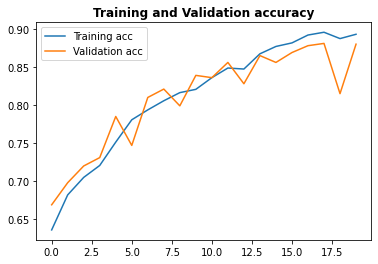

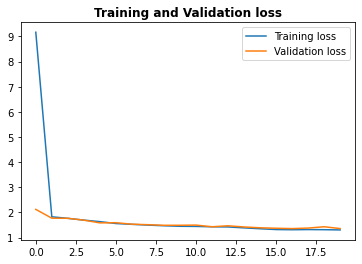

In [104]:
# get model results
model_results(loaded_cnn_model_5, train_images, train_y, test_images, test_y)

32/32 [==============================] - 2s 73ms/step


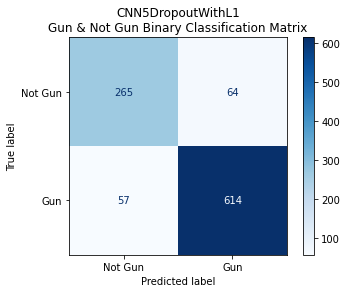

In [106]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model_5, test_images, test_y)

While the accuracy score is better than our CNN V3 model with L1 regularization, the recall score is not as good. 

### CNN Tuning V6

- Input node changed to 64 layers
- Added another Conv2D layer

In [203]:
cnn_model_6 = models.Sequential()
cnn_model_6._name = "CNN6"

cnn_model_6.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                          input_shape=(224, 224, 3)))

cnn_model_6.add(layers.Conv2D(32, (3,3), activation="relu")) # added another 32 conv. layer

cnn_model_6.add(layers.MaxPooling2D((2, 2), strides=(2,2))) # stride of 2

cnn_model_6.add(layers.Conv2D(64, (4, 4), activation='relu'))  # changed to 64 filters
cnn_model_6.add(layers.Conv2D(64, (3, 3), activation='relu')) # changed to 64 filters

cnn_model_6.add(layers.MaxPooling2D((2, 2), strides=(2,2))) # stride of 2

cnn_model_6.add(layers.Flatten())
cnn_model_6.add(layers.Dense(128,   # changed to 128 filters
                             activation='relu',
                             kernel_regularizer = reg_l1)) # keep l1 regularization

cnn_model_6.add(layers.Dense(1, activation='sigmoid'))  

cnn_model_6.compile(loss='binary_crossentropy',
                      optimizer="adam",  
                      metrics=['accuracy'])

**⏰ Below code runs for about 15 minutes**

In [204]:
# create a CNN model 5
cnn_model_6 = cnn_model_6.fit(train_images,
                                train_y,
                                epochs=20,
                                batch_size=64,
                                validation_data=(val_images, val_y),
                                callbacks=[trainCallback])

Epoch 1/20


2022-08-03 15:48:44.537194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - ETA: 0s - loss: 31.3434 - accuracy: 0.6280

2022-08-03 15:49:25.950788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 47s 968ms/step - loss: 31.3434 - accuracy: 0.6280 - val_loss: 10.2192 - val_accuracy: 0.6670
Epoch 2/20
47/47 [==============================] - 44s 939ms/step - loss: 9.5306 - accuracy: 0.6720 - val_loss: 9.1384 - val_accuracy: 0.6920
Epoch 3/20
47/47 [==============================] - 44s 940ms/step - loss: 9.0558 - accuracy: 0.6727 - val_loss: 8.7986 - val_accuracy: 0.6780
Epoch 4/20
47/47 [==============================] - 45s 958ms/step - loss: 8.8902 - accuracy: 0.6863 - val_loss: 8.9209 - val_accuracy: 0.6920
Epoch 5/20
47/47 [==============================] - 44s 948ms/step - loss: 8.7492 - accuracy: 0.6457 - val_loss: 8.5335 - val_accuracy: 0.6700
Epoch 6/20
47/47 [==============================] - 45s 950ms/step - loss: 8.3945 - accuracy: 0.6477 - val_loss: 8.2070 - val_accuracy: 0.6790
Epoch 7/20
47/47 [==============================] - 44s 940ms/step - loss: 8.6107 - accuracy: 0.7060 - val_loss: 8.8349 - val_accuracy: 0.7520
Epoch 8/

**.pkl the file**

In [209]:
# # use the built-in open() function to open a file
# output_file = open("cnn_model_6.pkl", "wb") # "wb" means "write as bytes"

# # dump the variable's contents into the file
# joblib.dump(cnn_model_6, output_file)

# # close the file, ensuring nothing stays in the buffer
# output_file.close()

In [206]:
# use the built-in open() function again, this time to read
cnn_model_6_file = open("cnn_model_6.pkl", "rb") # "rb" means "read as bytes"
# load the variable's contents from the file into a variable
loaded_cnn_model_6 = joblib.load(cnn_model_6_file)
# close the file
cnn_model_6_file.close()

### CNN Tuning V5 with Dropout & L1 Results

2022-08-03 16:04:02.216901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 6s 188ms/step - loss: 7.9410 - accuracy: 0.8750
Train Results Loss: 7.83609
Train Results Accuracy: 0.911
--------------------------------------------------
Test Results Loss: 7.94096
Test Results Accuracy: 0.875


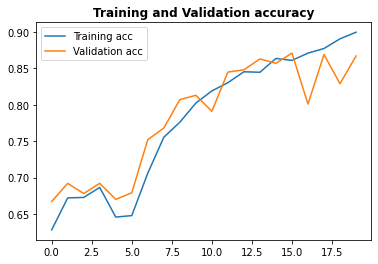

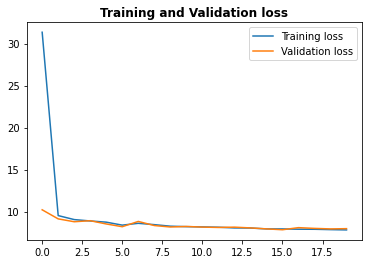

In [207]:
# get model results
model_results(loaded_cnn_model_6, train_images, train_y, test_images, test_y)

32/32 [==============================] - 6s 181ms/step - loss: 7.9410 - accuracy: 0.8750


2022-08-03 16:04:38.069868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 6s 175ms/step


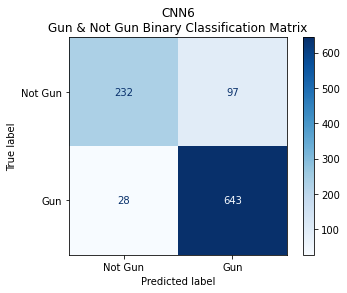

In [208]:
# get confusion matrix and test results for test image set
get_test_results(loaded_cnn_model_6, test_images, test_y)

## Predicting Images with MobileNet

In [244]:
from IPython.display import Image
mobile = keras.applications.mobilenet.MobileNet()

In [245]:
data_gun_dir = 'image_data/gun/'
data_not_gun_dir = 'image_data/not_gun/'

In [246]:
# function that prepares images for mobile net classification
def prepare_image(file):
    img_path = 'image_data/not_gun/' # location of images, change to image_data/not_gun to classify not guns
    img = load_img(img_path + file, target_size = (224,224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis = 0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [247]:
# select a random image from folder
image_name = str(np.random.choice(imgs_not_gun))  # change to imgs_not_gun to classify not guns

# define filename
filename = data_not_gun_dir + image_name
filename

'image_data/not_gun/0-1.jpg'

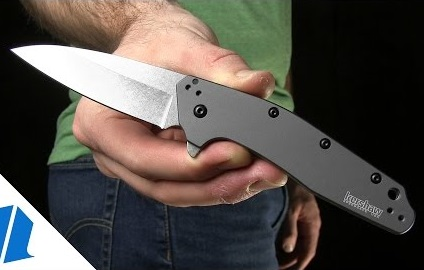

In [248]:
# what image was selected?
Image(filename = filename, width = 300, height = 200)

In [249]:
# process the image, return a prediction of the image
preprocessed_image = prepare_image(image_name)
predictions = mobile.predict(preprocessed_image)
results = tf.keras.applications.imagenet_utils.decode_predictions(predictions)
results

2022-08-03 17:14:37.860564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 350ms/step


[[('n03041632', 'cleaver', 0.6477464),
  ('n04141327', 'scabbard', 0.23451719),
  ('n04074963', 'remote_control', 0.042253114),
  ('n04086273', 'revolver', 0.015863894),
  ('n02951585', 'can_opener', 0.014446885)]]

## VGG16 Model 
## WORKING MODEL

In [149]:
vgg16_model = keras.applications.vgg16.VGG16()

In [150]:
model_with_vgg16 = models.Sequential()

for layer in vgg16_model.layers:
    model_with_vgg16.add(layer)

In [55]:
model_with_vgg16.pop()

In [56]:
for layer in model_with_vgg16.layers:
    layer.trainable = False


In [57]:
model_with_vgg16.add(layers.Dense(2, activation = 'softmax'))

In [58]:
model_with_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
train_images.shape

In [ ]:
model_with_vgg16.compile(loss='binary_crossentropy',
                          optimizer="sgd",
                          metrics=['accuracy'])

In [ ]:
train_labels

In [ ]:
import tensorflow as tf

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# create a CNN model
model_with_vgg16 = model_with_vgg16.fit(train_images,
                                        train_labels,
                                        epochs=5,
                                        steps_per_epoch = 30,
                                        validation_data=(val_images, val_labels),
                                        callbacks=[trainCallback])